In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

In [2]:
eog_tiles = gpd.GeoDataFrame(
    geometry = [
        shapely.box(-180, 0, -60, 75),
        shapely.box(-60, 0, 60, 75),
        shapely.box(60, 0, 180, 75),
        shapely.box(-180, -75, -60, 0),
        shapely.box(-60, -75, 60, 0),
        shapely.box(60, -75, 180, 0)
    ],
    crs = 4326
)

In [3]:
# import shoreline
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl"):
    shoreline = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine = "pyogrio")
    shoreline = shoreline.unary_union
    pickle.dump(shoreline, open("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl", "wb"))
else:
    shoreline = pickle.load(open("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl", "rb"))

In [ ]:
### RAMA

# please download annual night lights data from https://eogdata.mines.edu/nighttime_light/annual/v21/
# write a script to get all "median_masked" files and organize them in a adequate, clean folder structure
# mask out the shoreline (see below) (think about making all file paths in this notebook relative)
# assemble them into a single xarray/dask out-of-memory dataset that you export to .zarr

# some of this might be infeasible or impossible. In that case please let me know
# we might also use monthly data further down the road, but for now annual is fine

In [3]:
# import tile
tile = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/SVDNB_npp_20120401-20120430_00N060E_vcmcfg_v10_c201605121456.avg_rade9h.tif")
# import cloud free count
tile_cf = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/SVDNB_npp_20120401-20120430_00N060E_vcmcfg_v10_c201605121456.cf_cvg.tif")
# mask out no data
tile = tile.where(tile_cf != 0, np.nan)

In [144]:
# mask out water
tile = tile.rio.clip([shoreline])

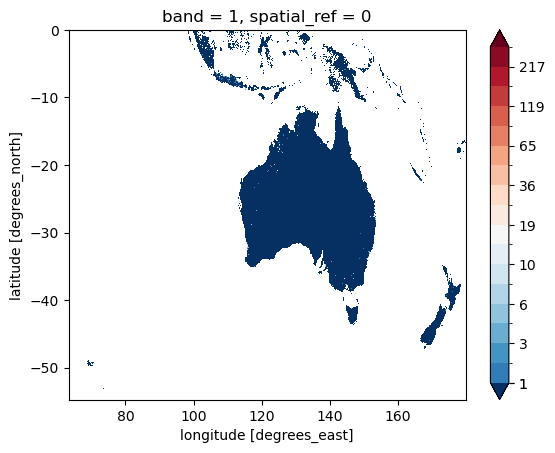

In [149]:
fig, ax = plt.subplots()
tile.squeeze().plot.imshow(ax = ax, levels = np.geomspace(1, test_subset.max(), num=20, dtype=int))

In [ ]:
# Save as Zarr
tile.to_zarr("Q:/HEALECON/Felix/Research/Heat Islands/data/test_processed.zarr", mode="w", consolidated=True)

---

In [106]:
test_boundary = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio").query("ADMIN=='Papua New Guinea'")

test_boundary.bounds.iloc[0]

minx    140.849211
miny    -11.636326
maxx    155.967540
maxy     -1.346368
Name: 160, dtype: float64

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

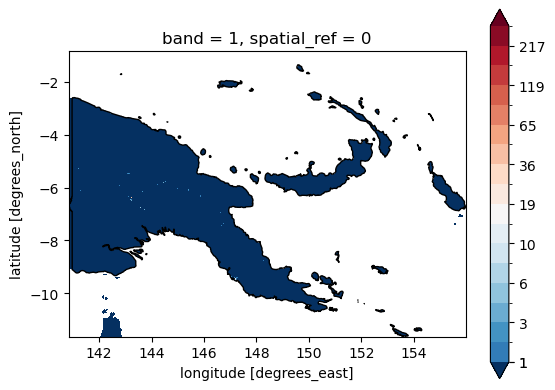

In [130]:
test_subset = test.rio.clip_box(*test_boundary.bounds.iloc[0])

fig, ax = plt.subplots()

test_subset.rio.clip([shoreline]).squeeze().plot.imshow(ax = ax, levels = np.geomspace(1, test_subset.max(), num=20, dtype=int))
test_boundary.plot(ax=ax, color = "none")

---

In [4]:
# load landsat wrs2 grid
landsat_wrs2 = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/WRS2_descending_0/WRS2_descending.shp", engine="pyogrio")

In [5]:
# filter out those not covering land
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl"):
    any_land = np.vstack([landsat_wrs2.intersects(list(shoreline.geoms)[i]) for i in range(len(shoreline.geoms))]).any(axis = 0)
    pickle.dump(any_land, open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "wb"))
else:
    any_land = pickle.load(open("Q:/HEALECON/Felix/Research/Heat Islands/data/any_land.pkl", "rb"))
landsat_wrs2_land = landsat_wrs2.loc[any_land,:]

<Axes: >

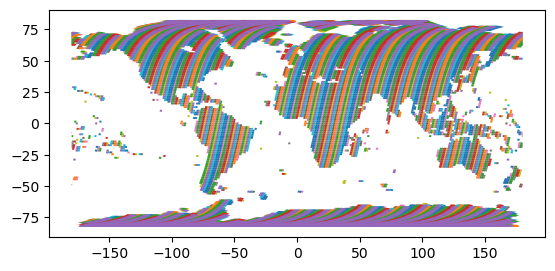

In [24]:
landsat_wrs2_land.plot(column = "ACQDayL7")

---

In [8]:
import ee

# import code_verifier and authorization_code from misc/ee_auth.txt
with open("Q:/HEALECON/Felix/Research/Heat Islands/misc/ee_auth.txt", "r") as f:
    code_verifier, authorization_code = f.read().split("\n")

# Trigger the authentication flow.
ee.Authenticate()# code_verifier=code_verifier, authorization_code = authorization_code
# Initialize the Earth Engine module
ee.Initialize(project = "ee-growthandheat")

In [9]:
# load the boundaries of Nepal
nepal = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio").query("ADMIN=='Nepal'")
# filter grid tiles covering Nepal
nepal_tiles = landsat_wrs2_land.loc[landsat_wrs2_land.intersects(nepal.unary_union),:]
# build ee filter object
nepal_filter = ee.Filter.Or([ee.Filter.And(ee.Filter.eq('WRS_PATH', int(path)), ee.Filter.eq('WRS_ROW', int(row))) for path, row in nepal_tiles[["PATH", "ROW"]].values])

In [10]:
# Load the Landsat 7 image collection
collection = (ee.ImageCollection('LANDSAT/LE07/C02/T1_L2')
    .filter(nepal_filter)
    #.filter(ee.Filter.And(ee.Filter.eq('WRS_PATH', 175), ee.Filter.eq('WRS_ROW', 83)))
    .filterDate('2015-01-01', '2015-03-31'))

# check if the collection is not empty
collection.size().getInfo() != 0

True

In [11]:
# Function to calculate a cloud score for a Landsat image
def cloud_score(image):
    blue = image.select('SR_B2')  # Blue band
    green = image.select('SR_B3')  # Green band
    red = image.select('SR_B4')  # Red band
    nir = image.select('SR_B5')  # Near-Infrared band
    swir1 = image.select('ST_B6')  # Shortwave Infrared 1 (Corrected band name)
    swir2 = image.select('SR_B7')  # Shortwave Infrared 2

    # Compute normalized differences
    ndsi = image.normalizedDifference(['SR_B3', 'ST_B6'])  # Snow Index
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4'])  # Vegetation Index

    # Brightness computation
    brightness = (blue.add(green).add(red).add(nir).add(swir1).add(swir2)).divide(6)

    # Cloud likelihood based on brightness and indices
    cloud_score = brightness.subtract(ndvi).add(ndsi).rename('cloud_score')

    # Normalize cloud score to [0,1] range
    cloud_score = cloud_score.divide(65535)

    return image.addBands(cloud_score)

# Function to apply cloud masking
def apply_cloud_mask(image):
    cloud_mask = image.select('cloud_score').lte(0.4)  # Keep only cloud-free pixels
    return image.updateMask(cloud_mask)

# Apply cloud mask to the collection
cloud_free_collection = collection.map(cloud_score).map(apply_cloud_mask)

# Print collection metadata
print('Landsat Cloud Free Collection:', cloud_free_collection.getInfo())

Landsat Cloud Free Collection: {'type': 'ImageCollection', 'bands': [], 'version': 1724299751217428, 'id': 'LANDSAT/LE07/C02/T1_L2', 'properties': {'date_range': [915148800000, 1649203200000], 'visualization_2_bands': 'SR_B7,SR_B4,SR_B2', 'visualization_2_name': 'Shortwave Infrared (742)', 'period': 0, 'type_name': 'ImageCollection', 'keywords': ['cfmask', 'cloud', 'etm', 'fmask', 'global', 'landsat', 'lasrc', 'lst', 'reflectance', 'sr', 'usgs'], 'visualization_1_bands': 'SR_B4,SR_B3,SR_B2', 'thumb': 'https://mw1.google.com/ges/dd/images/LANDSAT_SR_thumb.png', 'visualization_2_gain': '1.8,1.9,1.9', 'description': '<p>This dataset contains atmospherically corrected\nsurface reflectance and land surface temperature derived from the data\nproduced by the Landsat 7 ETM+ sensor.\nThese images contain 4 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and one thermal infrared (TIR) band processed to orthorectifie

In [12]:
# Compute the median using ee.Reducer.median
median = cloud_free_collection.select("ST_B6").reduce(ee.Reducer.median())

# Reproject
projected = median.reproject(
    crs='EPSG:4326',
    crsTransform=[0.0041666667, 0.0, 59.99791666665, 0.0, -0.0041666667, 0.00208333335]
)

# Transform into meaningful scale (based on USGS Landsat 7 ETM+ Collection 2 Level 2 Data Format Control Book, Table 3.2)
viewable = projected.multiply(0.00341802).add(149.0)

In [13]:
# Display the result
import geemap
Map = geemap.Map()
Map.centerObject(cloud_free_collection, 9)
st_params = {"min": 223.15, "max": 323.15, "palette": ['blue', 'white', 'green']}
Map.addLayer(viewable, st_params, "ST image")
Map

Map(center=[28.072510421089458, 83.88344505801915], controls=(WidgetControl(options=['position', 'transparent_…

In [65]:
# Export
export_task = ee.batch.Export.image.toCloudStorage(
    image=median.uint16(),
    description="nepal_cloud_free_st",
    bucket="growthandheat",
    region=cloud_free_collection.geometry().transform("EPSG:4326"),
    crs="EPSG:4326",
    crsTransform=[0.0041666667, 0.0, 59.99791666665, 0.0, -0.0041666667, 0.00208333335],
    scale=500
)
export_task.start()

---

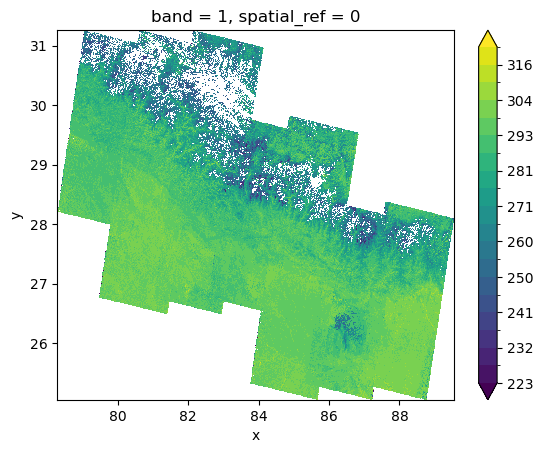

In [74]:
nepal_cloud_data = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/nepal_cloud_free_st.tif")
# plot in Kelvin
fig, ax = plt.subplots()
(nepal_cloud_data.where(nepal_cloud_data > 0, np.nan) * 0.00341802 + 149).squeeze().plot.imshow(ax = ax, levels = np.geomspace(223.15, 323.15, num=20, dtype=int))